# Binary classification of readers expertise using SVM

### Imports & Setup

In [2]:
# Creating the train and test sets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Get current working directory
cwd = Path().resolve()

# Go up to project root
project_root = cwd.parent

# Now go into the data/ subfolder
data_path = project_root / 'data_prep'

# Full file path
file_path = data_path / 'preprocessed_fixation_features_for_ml.csv'

# Load the dataset
et_data = pd.read_csv(file_path, sep="\t")
# Define the features and target variable
# Extract all features except 'is.expert' and 'participant_id'
features = et_data.columns.difference(['is.expert', 'Participant_unique']).tolist()

target = 'is.expert'
X = et_data[features]
y = et_data[target]

# Random state for reproducibility
random_state = 7

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

# Label binarization
lb = LabelBinarizer()
y_train_binary = lb.fit_transform(y_train).ravel()
y_test_binary = lb.transform(y_test).ravel()

# Preprocessor
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

cf_class_weight = 'balanced'
cf_max_iter = 10000

classifiers = [
    ('Linear', LinearSVC(class_weight=cf_class_weight, dual=False, max_iter=cf_max_iter, random_state=random_state)),
    ('RBF', SVC(kernel='rbf', class_weight=cf_class_weight, max_iter=cf_max_iter, random_state=random_state)),
    ('Poly', SVC(kernel='poly', class_weight=cf_class_weight, max_iter=cf_max_iter, random_state=random_state)),
    ('Logistic Regression', LogisticRegression(class_weight=cf_class_weight, max_iter=cf_max_iter, random_state=random_state)),
    ('Random Forest', RandomForestClassifier(class_weight=cf_class_weight, n_estimators=100, random_state=random_state))
]

### Baseline Models without Hyperparameter Tuning

In [8]:
for name, clf in classifiers:
    pipeline = ImPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=random_state)),
        ('classifier', clf)
    ])

    # Create a pipeline that first selects the best 50 features, then runs the model
    pipeline_with_fs = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])

    # Cross-validation on training data
    cv_scores = cross_val_score(pipeline, X_train, y_train_binary, cv=cv, scoring='f1_macro', verbose=1)

    print(f'\n======================================================')
    print(f'Model: {name}')
    print(f'Cross-Validation F1 Scores: {cv_scores}')
    print(f'Mean CV F1 Score: {cv_scores.mean():.3f}')


    # Train on full training data, then evaluate on test set
    pipeline.fit(X_train, y_train_binary)
    y_pred_binary = pipeline.predict(X_test)

    print('Test Set Classification Report:')
    print(classification_report(y_test_binary, y_pred_binary))

    if name == 'Random Forest':
        # Get the trained classifier step
        rf_classifier = pipeline.named_steps['classifier']

        # Get the feature names from the preprocessor step
        # This handles both numeric and one-hot encoded feature names
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

        # Create a pandas Series for easy viewing
        importances = pd.Series(rf_classifier.feature_importances_, index=feature_names)

        # Sort and display the top 15 most important features
        print('\nTop 15 Most Important Features (Random Forest):')
        print(importances.sort_values(ascending=False).head(15))

    if name == 'Linear':
        # Get the trained classifier and preprocessor
        linear_svc = pipeline.named_steps['classifier']
        preprocessor_step = pipeline.named_steps['preprocessor']

        # Get feature names
        feature_names = preprocessor_step.get_feature_names_out()

        # The coefficients are in a 2D array, so we take the first row
        coefficients = linear_svc.coef_[0]

        # Create a pandas Series
        importances = pd.Series(coefficients, index=feature_names)

        # To see the magnitude of importance, we use the absolute value
        print('\nTop 15 Most Influential Features (Linear SVM - by magnitude):')
        print(importances.abs().sort_values(ascending=False).head(15))

    if name == 'RBF':
        print('\nCalculating Permutation Importance for RBF SVM...')

        # 1. Manually transform the test data using the fitted preprocessor
        X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

        # 2. Get the final feature names AFTER transformation
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

        # 3. Run permutation_importance on the CLASSIFIER ONLY, using the TRANSFORMED data
        result = permutation_importance(
            pipeline.named_steps['classifier'], # Use the classifier, not the whole pipeline
            X_test_transformed,                 # Use the transformed data
            y_test_binary,
            n_repeats=10,
            random_state=random_state,
            n_jobs=-1,
            scoring='f1_macro'
        )

        # Now the lengths will match (both will be 91)
        perm_importances = pd.Series(result.importances_mean, index=feature_names)

        print('\nTop 15 Most Important Features (RBF SVM - by Permutation):')
        print(perm_importances.sort_values(ascending=False).head(15))


Model: Linear
Cross-Validation F1 Scores: [0.49230769 0.60294118 0.55592105 0.625      0.69318182]
Mean CV F1 Score: 0.594
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.70        38
           1       0.50      0.62      0.55        21

    accuracy                           0.64        59
   macro avg       0.63      0.64      0.63        59
weighted avg       0.67      0.64      0.65        59


Top 15 Most Influential Features (Linear SVM - by magnitude):
num__Total_duration_of_fixations_mean            1.713077
num__Number_of_whole_fixations_mean              1.649225
num__Number_of_whole_fixations_std               1.421022
num__Duration_of_first_whole_fixation_std        1.216573
num__Maximum_duration_of_fixations_mean          1.164955
num__Average_duration_of_fixations_std           1.153724
num__Total_duration_of_fixations_std             1.037293
num__Maximum_duration_of_whole_fixations_mean   

### GridSearchCV for Hyperparameter Tuning

In [3]:
param_grids = {
    'Linear': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__dual': [False],
    },
    'RBF': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto', 0.1, 1],
    },
    'Poly': {
        'classifier__C': [0.1, 1, 10],
        'classifier__degree': [2, 3, 4],
        'classifier__gamma': ['scale', 'auto'],
    },
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear'],
        'classifier__max_iter': [10000],
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5],
    }
}

In [6]:
best_models = {}

# Empy list to store all importances
all_importances_list = []

for random_state in [42, 41, 7]:
    print(f"\n\n{'='*20} RUNNING EXPERIMENT FOR RANDOM STATE: {random_state} {'='*20}")
    # --- Main Loop ---
    for name, clf in classifiers:
        # Set up the pipeline as before
        pipeline = ImPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=random_state)),
            ('classifier', clf)
        ])

        # Get the parameter grid for the current classifier
        param_grid = param_grids.get(name, {})

        # Set up and run GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='f1_macro',
            cv=cv,
            n_jobs=-1,
            verbose=0,
            refit=True  # refit=True is crucial, it retrains the best model on the whole training set
        )

        print(f'\n======================================================')
        print(f"Tuning hyperparameters for: {name}")
        grid_search.fit(X_train, y_train_binary)

        # --- Analysis of the BEST model ---
        print(f'\nModel: {name}')
        print(f'Best Parameters: {grid_search.best_params_}')
        print(f'Best CV F1 Score: {grid_search.best_score_:.3f}')

        # Evaluate the best model on the test set
        y_pred_binary = grid_search.predict(X_test)
        print('\nTest Set Classification Report:')
        print(classification_report(y_test_binary, y_pred_binary))

        # Store the best pipeline for later use
        best_models[name] = grid_search.best_estimator_

        # ==============================================================
        # === FEATURE IMPORTANCE FOR THE BEST ESTIMATOR ===
        # ==============================================================

        # Get the best pipeline found by GridSearchCV. This is the model we want to interpret.
        best_pipeline = grid_search.best_estimator_

        print("\n--- Feature Importance Analysis ---")

        # Use the appropriate method based on the model type
        if name == 'Random Forest':
            rf_classifier = best_pipeline.named_steps['classifier']
            feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
            importances = pd.Series(rf_classifier.feature_importances_, index=feature_names)
            # Save all features importances
            for feature, importance in importances.items():
                all_importances_list.append({
                    'Model': name,
                    'Feature': feature,
                    'Importance': importance
                })
            print('Top 5 Most Important Features (from best Random Forest):')
            print(importances.sort_values(ascending=False).head(5))

        elif name == 'Linear' or (name == 'Logistic Regression' and grid_search.best_params_.get('classifier__solver') == 'liblinear'):
            classifier = best_pipeline.named_steps['classifier']
            feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
            coefficients = classifier.coef_[0]
            importances = pd.Series(coefficients, index=feature_names)
            # Save all features importances
            for feature, importance in importances.items():
                all_importances_list.append({
                    'Model': name,
                    'Feature': feature,
                    'Importance': importance
                })
            print(f'Top 5 Most Influential Features (from best {name} - by magnitude):')
            print(importances.abs().sort_values(ascending=False).head(5))

        else:
            print(f'Calculating Permutation Importance for best {name} model...')
            X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
            feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
            result = permutation_importance(
                best_pipeline.named_steps['classifier'],
                X_test_transformed,
                y_test_binary,
                n_repeats=10,
                random_state=random_state,
                n_jobs=-1,
                scoring='f1_macro'
            )
            perm_importances = pd.Series(result.importances_mean, index=feature_names)
            # Save all features importances
            for feature, importance in perm_importances.items():
                all_importances_list.append({
                    'Model': name,
                    'Feature': feature,
                    'Importance': importance
                })
            print(f'\nTop 5 Most Important Features (from best {name} - by Permutation):')
            print(perm_importances.sort_values(ascending=False).head(5))

# Save all importances to a CSV file
all_importances = pd.DataFrame(all_importances_list)
all_importances.to_csv('all_feature_importances_with_selection.csv', index=False)




==================== RUNNING EXPERIMENT FOR RANDOM STATE: 42 ====================

Tuning hyperparameters for: Linear

Model: Linear
Best Parameters: {'classifier__C': 0.01, 'classifier__dual': False}
Best CV F1 Score: 0.607

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        25
           1       0.38      0.64      0.47        14

    accuracy                           0.49        39
   macro avg       0.52      0.52      0.49        39
weighted avg       0.56      0.49      0.49        39


--- Feature Importance Analysis ---
Top 5 Most Influential Features (from best Linear - by magnitude):
num__Minimum_duration_of_fixations_min        0.138763
cat__text.type_clinical                       0.137287
num__Time_to_first_fixation_min               0.120270
num__Time_to_first_whole_fixation_max         0.112185
num__Total_duration_of_whole_fixations_max    0.107118
dtype: float64

Tuning hyperparame

## Confusion Matrix of the best model

Best Model: RBF
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        38
           1       0.75      0.57      0.65        21

    accuracy                           0.78        59
   macro avg       0.77      0.73      0.74        59
weighted avg       0.78      0.78      0.77        59



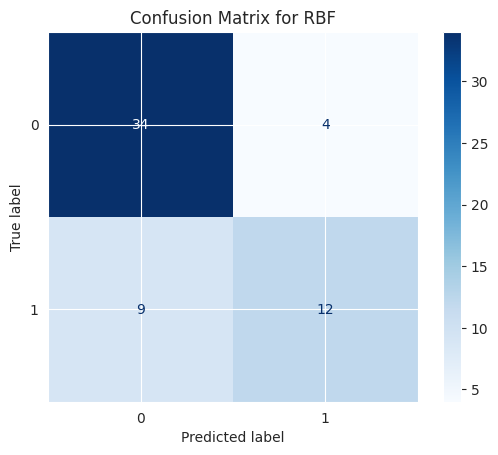

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

# Choose best model(s) - here using Poly_SVC
best_model_name = max(best_models, key=lambda k: best_models[k].score(X_test, y_test_binary))
best_model = best_models[best_model_name]

print(f"Best Model: {best_model_name}")
y_pred_binary = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

# Confusion Matrix plot
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test_binary, cmap='Blues')
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()


<Figure size 800x600 with 0 Axes>

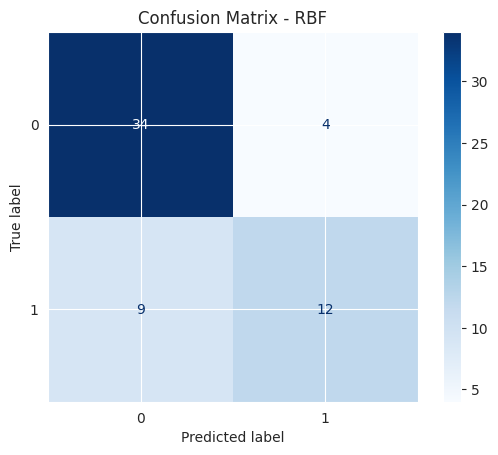

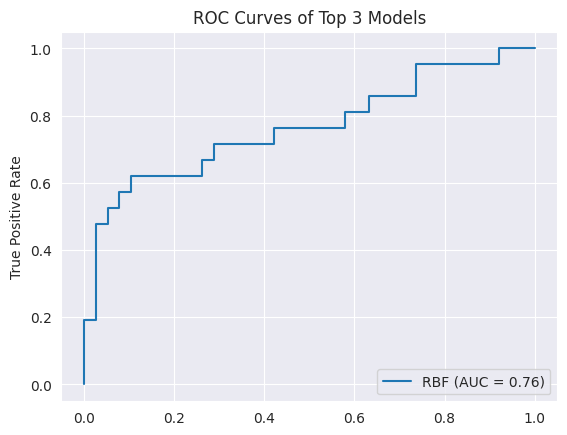

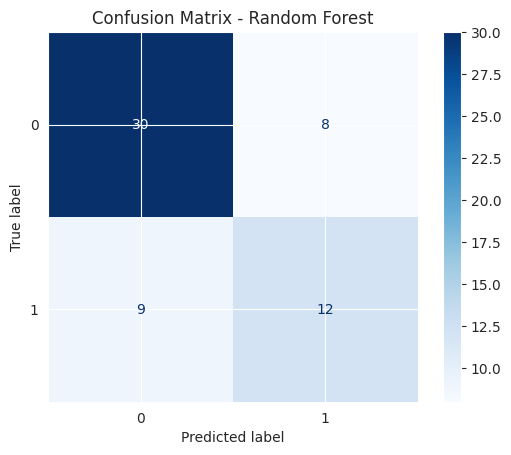

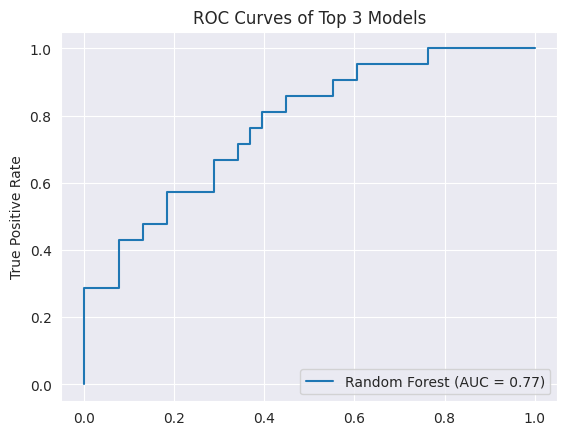

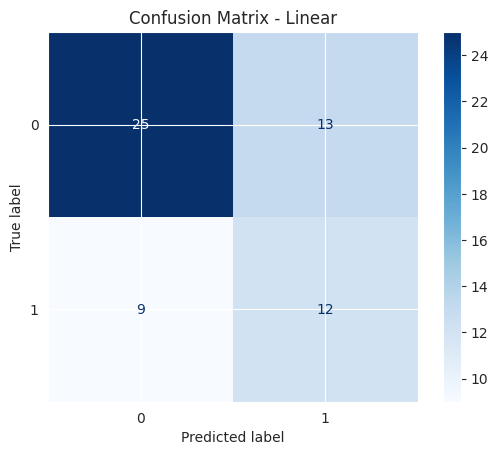

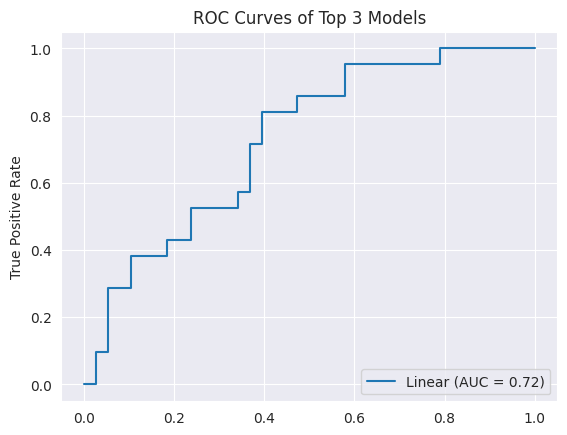

In [12]:
# Sort models by score in descending order and take the top 3
top3_model_names = sorted(
    best_models,
    key=lambda k: best_models[k].score(X_test, y_test_binary),
    reverse=True
)[:3]

plt.figure(figsize=(8, 6))

for name in top3_model_names:
    model = best_models[name]
    y_pred = model.predict(X_test)

    # For ROC: get predicted probabilities
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        # For SVM without predict_proba, use decision_function
        y_prob = model.decision_function(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test_binary, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')  # Use blue shades
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of Top 3 Models')
    plt.legend(loc='lower right')
    plt.show()

In [68]:
# Check balancedness of the dataset
print("Dataset Balance:")
print(y.value_counts(normalize=True))

Dataset Balance:
is.expert
non-expert    0.64
expert        0.36
Name: proportion, dtype: float64
